# Forecasting Realized Volatility

The goal of this notebook is to fit a simple HAR-RV model to forecast the SPY realized volatility.  This model assumes that investors with different time horizons percieve volatility differently [Muller et al.(1993)](https://ssrn.com/abstract=5370). 


Therefore, we will try to forecast the realized volatility in one day by taking into account the RV of the previous day, the previous week, the previous month.

The main papers followed to implement the simple HAR-RV are:
- Haugom, Erik and Langeland, Henrik and Molnár, Peter and Westgaard, Sjur, Forecasting Volatility of the U.S. Oil Market (January 29, 2014). Available at SSRN: https://ssrn.com/abstract=2691391
- Corsi, Fulvio, A Simple Long Memory Model of Realized Volatility (August 18, 2004). Available at SSRN: https://ssrn.com/abstract=626064 

I have adapted the workbook from here: https://github.com/deep-hedger-Peng/HAR-RV/blob/master/HAR-RV_forecast.ipynb

In [2]:
# Required packages
import pandas as pd
import numpy as np 
import warnings

import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller as adf
from statsmodels.graphics.gofplots import qqplot
from pandas.plotting import register_matplotlib_converters
from pandas.plotting import autocorrelation_plot

In [3]:
%matplotlib inline
register_matplotlib_converters()
warnings.filterwarnings('ignore')

### 1. $\quad$ Data

Realized volatility data is not freely available. Instead, we will use quasi-maximum likelihood estimates of volatility (QMLE) based on moving-average models MA(q), available from Dacheng Xiu's website:

https://dachxiu.chicagobooth.edu/?_gl=1*15f3sfe*_gcl_au*MjEyMDQ4NjQ3OC4xNzUzMjM4MjUy

#### 1.1. $\quad$ Import the data


We then import the data.

In [4]:
rv = pd.read_csv("download.csv")
rv = rv[["Date", "Volatility", "Type"]]
rv.rename(columns={"Volatility": "RV_daily"},inplace=True)
rv = rv[rv['Type'] == 'QMLE-Trade']
rv.drop(columns=['Type'], inplace=True)
rv = rv.set_index("Date")
rv.index = pd.to_datetime(rv.index)
rv.index.name = "date"

rv.head()

,RV_daily
date,
1996-01-02,0.140261
1996-01-03,0.082399
1996-01-04,0.211454
1996-01-05,0.022647
1996-01-09,0.228727


#### 1.2. $\quad$ Data pre-processing

We can compute the weekly and monthly RV with:
- Weekly : $RV^w_t = \frac{1}{5} \left(RV^d_{t-1d} + RV^d_{t-2d} + \dots + RV^d_{t-1w}\right)$
- Monthly : $RV^m_t = \frac{1}{21} \left(RV^d_{t-1d} + RV^d_{t-2d} + \dots + RV^d_{t-1m}\right)$

In [5]:
# Compute weekly and monthly RV.  
rv["RV_weekly"] = rv["RV_daily"].rolling(5).mean()
rv["RV_monthly"] = rv["RV_daily"].rolling(21).mean()
rv.dropna(inplace = True)

In [6]:
# Check for stationarity with adf test
print("p-value for daily RV:", adf(rv["RV_daily"].values)[1])
print("p-value for weekly RV:",adf(rv["RV_weekly"].values)[1])
print("p-value for monthly RV:",adf(rv["RV_monthly"].values)[1])

p-value for daily RV: 1.8783199953443305e-10
p-value for weekly RV: 1.289214893667217e-09
p-value for monthly RV: 8.022823459638534e-09


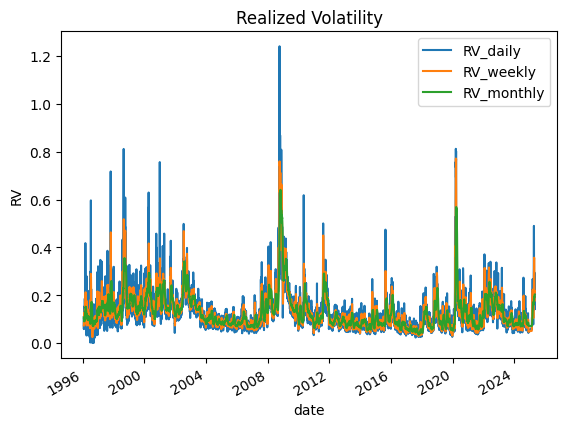

In [7]:
# Plot the RV variables.  
rv[["RV_daily","RV_weekly","RV_monthly"]].plot(title = f"Realized Volatility")
plt.ylabel("RV")
plt.show()

Define the target, as well as the in-sample and out-of-sample periods.

In [8]:
# Prepare data 
rv["Target"] = rv["RV_daily"].shift(-1) #We want to predict the RV of the next day.  
rv.dropna(inplace = True)

#Add constant c
rv = sm.add_constant(rv)

#Split train and test sets
split = int(0.60 * rv.shape[0])
X = rv.drop("Target", axis = 1)
y = rv[["Target"]]
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

### 2. $\quad$ Fitting and evaluating and the model

We can now train the parameters for HAR. 

$\hat{RV_{t+1d}^{d}} = \hat{\beta_0} + \hat{\beta_1} RV_t^d + \hat{\beta_2} RV_t^w + \hat{\beta_3} RV_t^m$

We do this with OLS:

$\hat{\beta} = (X'X)^{-1}X'Y$

In [9]:
results = sm.OLS(y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Target   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     3447.
Date:                Thu, 07 Aug 2025   Prob (F-statistic):               0.00
Time:                        16:32:17   Log-Likelihood:                 7047.2
No. Observations:                4368   AIC:                        -1.409e+04
Df Residuals:                    4364   BIC:                        -1.406e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0084      0.002      5.109      0.000       0.005       0.012
RV_daily       0.4239      0.018     24.033      0.000       0.389       0.458
RV_weekly      0.3373      0.028     12.253      0.000       0.283       0.391
RV_monthly     0.1819      0.022      8.086      0.000       0.138       0.226
==============================================================================
Omnibus:                     2773.439   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           129115.504
Skew:                           2.395   Prob(JB):                         0.00
Kurtosis:                      29.201   Cond. No.                         48.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [3]:
# Perform out of sample prediction
y_hat = results.predict(X_test)

plt.figure(figsize = (14,5))

#Predicted RV
plt.subplot(1,2,1)
plt.plot(y_test.index, y_hat)
plt.title("Predicted RV")

#Actual RV
plt.subplot(1,2,2)
plt.plot(y_test.index, y_test, color = "orange")
plt.title("Actual RV")
plt.show()

plt.scatter(y_test, y_hat)
plt.title("Predicted vs observed RV")
plt.show()


NameError: name 'results' is not defined

In [4]:
# Metrics
def score(y_hat, y, metric):
    """Return metrics of y_hat vs. y

    Args:
        y_hat (np.array): Predicted values
        y (np.array): Actual values
        metric (str): Metric to use

    Returns:
        float: The metric
    """
    if metric == "MSE": 
        return np.mean( (y_hat-y)**2)
    elif metric == "R_squared":
        ss_res = np.sum( (y - y_hat)**2 )
        ss_tot = np.sum( (y - np.average(y)) **2)
        return 1 - ss_res/ss_tot
    elif metric == "MAE":
        return np.mean( np.abs(y-y_hat))

In [12]:
#In-sample scores
print("In-sample scores")

y_hat_is = results.predict(X_train)
mse_is = score(y_hat_is, y_train.values.ravel(), "MSE")
r_sq_is = score(y_hat_is, y_train.values.ravel(), "R_squared")
mae_is = score(y_hat_is, y_train.values.ravel(), "MAE")

print(f"MSE:{mse_is}, R^2:{r_sq_is}, MAE:{mae_is}")      

print("----------------")
               
#Out-of-sample scores
print("Out-of-sample scores")
               
mse_oos = score(y_hat, y_test.values.ravel(), "MSE")
r_sq_oos = score(y_hat, y_test.values.ravel(), "R_squared")
mae_oos = score(y_hat, y_test.values.ravel(), "MAE")

print(f"MSE:{mse_oos}, R^2:{r_sq_oos}, MAE:{mae_oos}")

In-sample scores
MSE:0.0023236619726939444, R^2:0.7032141146488948, MAE:0.02960236196160319
----------------
Out-of-sample scores
MSE:0.00112073983069868, R^2:0.7693064499579718, MAE:0.0223639492470913


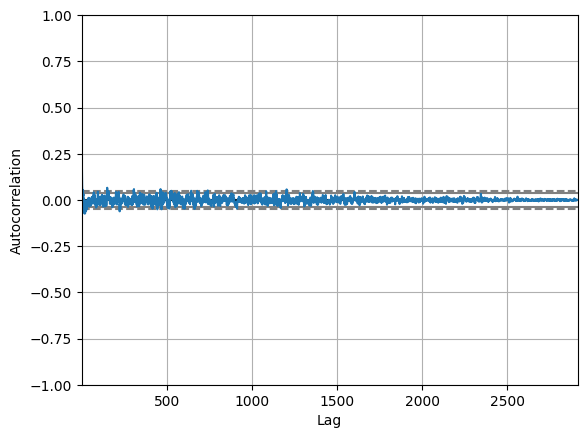

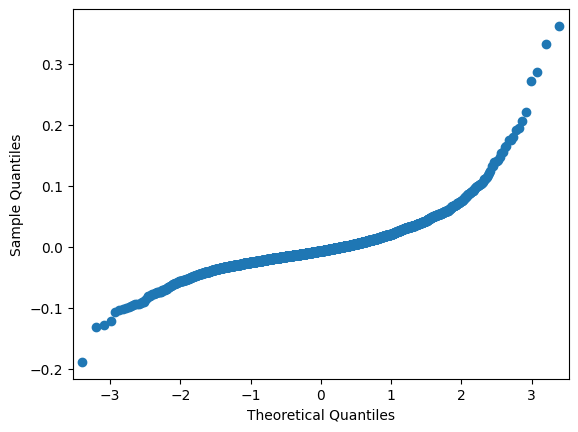

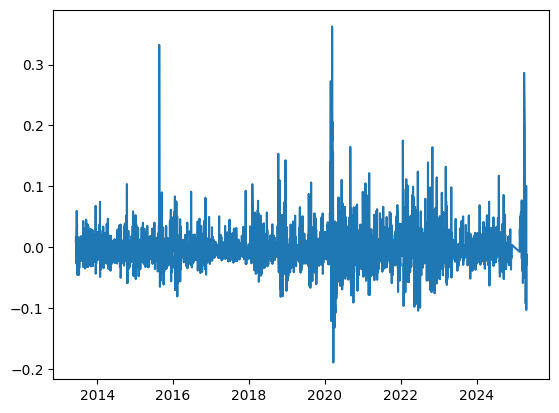

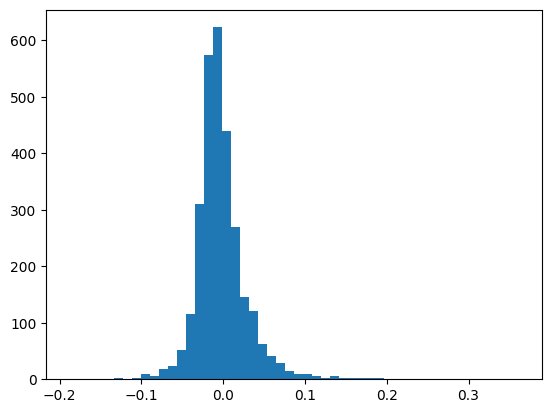

In [13]:
# Residuals
residuals = y_test.values.ravel() - y_hat

autocorrelation_plot(residuals);plt.show()
qqplot(residuals);plt.show()
plt.plot(residuals);plt.show()
plt.hist(residuals, bins = 50); plt.show()